<a href="https://colab.research.google.com/github/mibrahim09/corona-ct/blob/master/Corona_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data

Imports

In [ ]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

Pytorch Transforms

In [ ]:
Training_Transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.Grayscale(num_output_channels=1), 
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
])
Test_Transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.Grayscale(num_output_channels=1), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

class CoronaDataset(torch.utils.data.Dataset):
      def __init__(self, image_dirs,transform):
                def get_images(class_name):
                  images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
                  return images
                self.images={}
                self.class_names=['Normal','Viral','COVID']
                for c in self.class_names:
                    self.images[c]=get_images(c)
                self.image_dirs=image_dirs
                self.transform=transform
      def __len__(self):
                return sum([len(self.images[c]) for c in self.class_names])
      def __getitem__(self, index):
                class_name=random.choice(self.class_names)
                index=index%len(self.images[class_name])
                image_name=self.images[class_name][index]
                image_path =os.path.join(self.image_dirs[class_name], image_name)
                image=Image.open(image_path).convert('RGB')
                return self.transform(image), self.class_names.index(class_name)

Loading Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Files_Directory = {
    'Normal': '/content/drive/MyDrive/COVID/NORMAL',
    'Viral': '/content/drive/MyDrive/COVID/Viral Pneumonia',
    'COVID': '/content/drive/MyDrive/COVID/COVID'
}
dataset=CoronaDataset(Files_Directory, Training_Transform)

Split for training and validation

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
#validation_split = .2

test_train_split=0.8
val_train_split=0.1

dataset_size = len(dataset)
indices = list(range(dataset_size))


#split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_train_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)

#train_indices, val_indices = indices[split:], indices[:split]
train_indices, test_indices = indices[:test_split], indices[test_split:]
train_size = len(train_indices)
validation_split = int(np.floor((1 - val_train_split) * train_size))
train_indices, val_indices = train_indices[ : validation_split], train_indices[validation_split:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)
print('LOADING DONE!')
print('Training len: ' + str(len(train_loader)))
print('Validation len: ' + str(len(validation_loader)))
print('Testing len: ' + str(len(test_loader)))

LOADING DONE!
Training len: 140
Validation len: 16
Testing len: 39


Showing some images

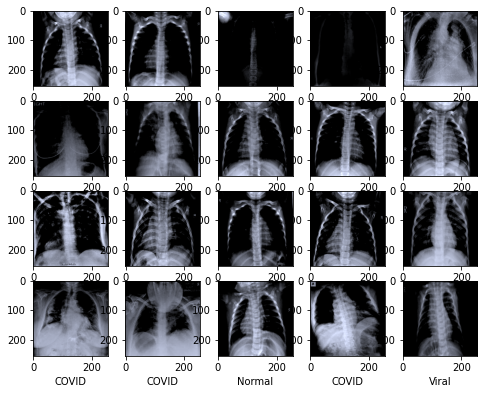

In [ ]:
Classes=['Normal','Viral','COVID']
imgs, labels = next(iter(train_loader))
fig=plt.figure(figsize=(8, 8))
columns = batch_size / 4
rows = 5
i = 0
for img in imgs:
    myLabel = labels[i]
    i = i+1
    fig.add_subplot(rows, columns, i)
    img=img.numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std= np.array([0.229, 0.224, 0.225])
    img=img*std/mean
    img=np.clip(img,0.,1.)
    plt.imshow(img)
    plt.xlabel(Classes[myLabel])
plt.show()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# ***Fully Connected***

**Neural Network Implementation**


In [ ]:
from torch import nn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def train_model(model,train_loader,validation_loader,test_loader):
  num_epochs = 5
  learning_rate = 0.0001

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5, threshold=1e-4)

  # Train the model
  total_step = len(train_loader)
  correct = 0
  total = 0
  for epoch in range(num_epochs):
      epoch_loss = 0
      epoch_acc = 0
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.view(-1, 256*256).to(device) #### THIS LINE (1,256,256) = > (256,256)
          labels = labels.to(device)
        
          # Forward pass
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          epoch_loss += loss.item()

          # Backprpagation and optimization  
          loss.backward()
          optimizer.step()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          correct_results_sum = (predicted == labels).sum().float()
          acc = correct_results_sum/labels.shape[0]
          acc = torch.round(acc * 100)
          
          epoch_acc += acc.item()

          f1score = f1_score(labels, predicted, average='micro')
          
      print ('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}' 
            .format(epoch+1, num_epochs,epoch_loss/total_step, epoch_acc/total_step))
                      
  print(f'Accuracy (Training) : {format(100 * correct / total)}% ---> F1 score: {round(f1score, 4)}')

  # Test the model
  # In the test phase, don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
      correct1 = 0
      total1 = 0
      correct2 = 0
      total2 = 0
      for images1, labels1 in validation_loader:
          images1 = images1.reshape(-1, 256*256).to(device)
          labels1 = labels1.to(device)
          outputs1 = model(images1)
          _, predicted1 = torch.max(outputs1.data, 1)
          total1 += labels1.size(0)
          correct1 += (predicted1 == labels1).sum().item()
          f1score1 = f1_score(labels1, predicted1, average='micro')

      print(f'Accuracy (Validation) : {format(100 * correct1 / total1)}% ---> F1 score: {round(f1score1, 4)}')
      
      for images2, labels2 in test_loader:
          images2 = images2.reshape(-1, 256*256).to(device)
          labels2 = labels2.to(device)
          outputs2 = model(images2)
          _, predicted2 = torch.max(outputs2.data, 1)
          total2 += labels2.size(0)
          correct2 += (predicted2 == labels2).sum().item()
          f1score2 = f1_score(labels2, predicted2, average='micro')

      print(f'Accuracy (Testing) : {format(100 * correct2 / total2)}% ---> F1 score: {round(f1score2, 4)}')


# ***`1.Many Layers`***


In [ ]:
from torch import nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size) 
        self.fc5 = nn.Linear(hidden_size, hidden_size) 
        self.fc6 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

In [ ]:
input_size = 256*256
hidden_size = 256
num_classes = 10

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
train_model(model,train_loader,validation_loader,test_loader)

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Loss: 0.5143, Acc: 80.9143
Epoch [2/5], Loss: 0.2500, Acc: 90.6929
Epoch [3/5], Loss: 0.2247, Acc: 91.3429
Epoch [4/5], Loss: 0.1895, Acc: 93.3357
Epoch [5/5], Loss: 0.1756, Acc: 93.7071
Accuracy (Training) : 90.00357525920629% ---> F1 score: 0.9412
Accuracy (Validation) : 94.21221864951768% ---> F1 score: 1.0
Accuracy (Testing) : 95.24421593830334% ---> F1 score: 0.9444


# ***`2.Few Layers`***


In [ ]:
from torch import nn
import torch.nn.functional as F

class NeuralNet_Few_Layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet_Few_Layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
input_size = 256*256
hidden_size = 256
num_classes = 10

model_Few_Layers = NeuralNet_Few_Layers(input_size, hidden_size, num_classes).to(device)
train_model(model_Few_Layers,train_loader,validation_loader,test_loader)
# Save the model checkpoint
torch.save(model_Few_Layers.state_dict(), 'model_Few_Layers.ckpt')

Epoch [1/5], Loss: 0.3822, Acc: 85.1857
Epoch [2/5], Loss: 0.2291, Acc: 91.6714
Epoch [3/5], Loss: 0.2182, Acc: 91.5286
Epoch [4/5], Loss: 0.1835, Acc: 93.1071
Epoch [5/5], Loss: 0.1681, Acc: 94.2071
Accuracy (Training) : 91.1405076868073% ---> F1 score: 0.9412
Accuracy (Validation) : 92.92604501607717% ---> F1 score: 1.0
Accuracy (Testing) : 94.60154241645245% ---> F1 score: 1.0


# ***CNN***


# ***`1.Many Layers`***

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNNNeuralNetManyLayers(nn.Module):
      def __init__(self):
        super(CNNNeuralNetManyLayers, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 4)
        self.conv3 = nn.Conv2d(16, 256, 5)
        # linear layers
        self.fc1 = nn.Linear(29*29*256, 256) 
        self.fc2 = nn.Linear(256,120)
        self.fc3 = nn.Linear(120, 64)
        self.fc4 = nn.Linear(64, 10) 

      # x represents our data
      def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = F.max_pool2d(F.relu(self.conv1(x)),2) #256-3+1 = 254/2 = 127
        x = F.max_pool2d(F.relu(self.conv2(x)),2) #127-4+1 = 124/2 = 62
        x = F.max_pool2d(F.relu(self.conv3(x)),2) #62-5+1 = 58/2 = 29
        # flattening the image
        x = x.view(-1, 29*29*256) 
        # linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = CNNNeuralNetManyLayers()
print(model)

CNNNeuralNetManyLayers(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=215296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5, threshold=1e-4)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# epochs to train for
epochs = 5

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

# tracking Training loss
class_correct_train = list(0. for i in range(10))
class_total_train = list(0. for i in range(10))

for epoch in range(1, epochs+1):
    
    train_loss = 0
    valid_loss = 0
    test_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update training loss
        train_loss += loss.item()*data.size(0)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        f1score = f1_score(target, pred, average='micro')
        #accuracyScore = accuracy_score(target, pred)

        # calculate validation accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct_train[label] += correct[i].item()
            class_total_train[label] += 1
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(validation_loader):
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)

    # Testing steps
    for batch_index, (data, target) in enumerate(test_loader):
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        test_loss += loss.item()*data.size(0)
        
    # average loss calculations
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    test_loss = test_loss/len(test_loader.sampler)
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}  Training Loss: {round(train_loss, 6)}\tValidation Loss: {round(valid_loss, 6)}\tTesting Loss: {round(test_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

Current Epoch: 1  Training Loss: 0.570414	Validation Loss: 0.248678	Testing Loss: 0.237333
Validation loss decreased from inf to 0.248678
Saving New Model
Current Epoch: 2  Training Loss: 0.224833	Validation Loss: 0.188994	Testing Loss: 0.221278
Validation loss decreased from 0.248678 to 0.188994
Saving New Model
Current Epoch: 3  Training Loss: 0.19071	Validation Loss: 0.182594	Testing Loss: 0.145076
Validation loss decreased from 0.188994 to 0.182594
Saving New Model
Current Epoch: 4  Training Loss: 0.156622	Validation Loss: 0.135081	Testing Loss: 0.146017
Validation loss decreased from 0.182594 to 0.135081
Saving New Model
Current Epoch: 5  Training Loss: 0.138119	Validation Loss: 0.161912	Testing Loss: 0.181866


Checking accuracy

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# tracking validation loss
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# tracking test loss
test_loss = 0.0
class_correct_2 = list(0. for i in range(10))
class_total_2 = list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(validation_loader):
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # validation loss update
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    f1score1 = f1_score(target, pred, average='micro')
    #accuracyScore1 = accuracy_score(target, pred)

    # calculate validation accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for batch_idx, (data, target) in enumerate(test_loader):
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    f1score2 = f1_score(target, pred, average='micro')
    #accuracyScore2 = accuracy_score(target, pred)
    
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct_2[label] += correct[i].item()
        class_total_2[label] += 1

# average validation & test loss
valid_loss = valid_loss/len(validation_loader.dataset)
test_loss = test_loss/len(test_loader.dataset)

for i in range(3):
    if class_total[i] > 0:
        print(f'Training Accuracy of {Classes[i]}: {round(100*class_correct_train[i]/class_total_train[i], 2)}%')
    else:
        print(f'Training Accuracy of {Classes[i]}s: N/A (no training examples)')

print(f'Full Training Accuracy: {round(100. * np.sum(class_correct_train) / np.sum(class_total_train), 2)}% {np.sum(class_correct_train)} out of {np.sum(class_total_train)} ---> F1 score: {round(f1score, 4)}')
#print(f'Training Accuracy By accuracyScore: {round(accuracyScore, 4)}')

print(f'\nValidation Loss: {round(valid_loss, 4)}')
for i in range(3):
    if class_total[i] > 0:
        print(f'Validation Accuracy of {Classes[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Validation Accuracy of {Classes[i]}s: N/A (no training examples)')

print(f'Full Validation Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} out of {np.sum(class_total)} ---> F1 score: {round(f1score1, 4)}')
print(f'Validation Accuracy By accuracyScore: {round(accuracyScore1, 4)}')

print(f'\nTest Loss: {round(test_loss, 4)}')
for i in range(3):
    if class_total_2[i] > 0:
        print(f'Test Accuracy of {Classes[i]}: {round(100*class_correct_2[i]/class_total_2[i], 2)}%')
    else:
        print(f'Test Accuracy of {Classes[i]}s: N/A (no training examples)')
        
print(f'Full Test Accuracy: {round(100. * np.sum(class_correct_2) / np.sum(class_total_2), 2)}% {np.sum(class_correct_2)} out of {np.sum(class_total_2)} ---> F1 score: {round(f1score2, 4)}')
print(f'Test Accuracy By accuracyScore: {round(accuracyScore2, 4)}')

Training Accuracy of Normal: 89.37%
Training Accuracy of Viral: 88.47%
Training Accuracy of COVID: 92.24%
Full Training Accuracy: 90.03% 12590.0 out of 13985.0 ---> F1 score: 0.9412

Validation Loss: 0.0142
Validation Accuracy of Normal: 99.05%
Validation Accuracy of Viral: 82.47%
Validation Accuracy of COVID: 95.41%
Full Validation Accuracy: 92.6% 288.0 out of 311.0 ---> F1 score: 0.9091


NameError: ignored

# ***`2.Few Layers`***

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNNNeuralNet(nn.Module):
      def __init__(self):
        super(CNNNeuralNet, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        # linear layers
        self.fc1 = nn.Linear(61*61*16, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10) 

      # x represents our data
      def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        # flattening the image
        x = x.view(-1, 61*61*16)
        # linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = CNNNeuralNet()
print(model)

In [ ]:
import torch.optim as optim

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5, threshold=1e-4)

In [ ]:
from sklearn.metrics import f1_score

# epochs to train for
epochs = 5

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

# tracking Training loss
class_correct_train = list(0. for i in range(10))
class_total_train = list(0. for i in range(10))

for epoch in range(1, epochs+1):
    
    train_loss = 0
    valid_loss = 0
    test_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update training loss
        train_loss += loss.item()*data.size(0)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        f1score = f1_score(target, pred, average='micro')
        # calculate validation accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct_train[label] += correct[i].item()
            class_total_train[label] += 1
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(validation_loader):
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)

    # Testing steps
    for batch_index, (data, target) in enumerate(test_loader):
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        test_loss += loss.item()*data.size(0)
        
    # average loss calculations
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    test_loss = test_loss/len(test_loader.sampler)
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}  Training Loss: {round(train_loss, 6)}\tValidation Loss: {round(valid_loss, 6)}\tTesting Loss: {round(test_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

Checking accuracy

In [ ]:
from sklearn.metrics import f1_score

# tracking validation loss
valid_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# tracking test loss
test_loss = 0.0
class_correct_2 = list(0. for i in range(10))
class_total_2 = list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(validation_loader):
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # validation loss update
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    f1score1 = f1_score(target, pred, average='micro')
    # calculate validation accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for batch_idx, (data, target) in enumerate(test_loader):
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    f1score2 = f1_score(target, pred, average='micro')
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct_2[label] += correct[i].item()
        class_total_2[label] += 1

# average validation & test loss
valid_loss = valid_loss/len(validation_loader.dataset)
test_loss = test_loss/len(test_loader.dataset)

for i in range(3):
    if class_total[i] > 0:
        print(f'Training Accuracy of {Classes[i]}: {round(100*class_correct_train[i]/class_total_train[i], 2)}%')
    else:
        print(f'Training Accuracy of {Classes[i]}s: N/A (no training examples)')

print(f'Full Training Accuracy: {round(100. * np.sum(class_correct_train) / np.sum(class_total_train), 2)}% {np.sum(class_correct_train)} out of {np.sum(class_total_train)} ---> F1 score: {round(f1score, 4)}')

print(f'\nValidation Loss: {round(valid_loss, 4)}')
for i in range(3):
    if class_total[i] > 0:
        print(f'Validation Accuracy of {Classes[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Validation Accuracy of {Classes[i]}s: N/A (no training examples)')

print(f'Full Validation Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} out of {np.sum(class_total)} ---> F1 score: {round(f1score1, 4)}')

print(f'\nTest Loss: {round(test_loss, 4)}')
for i in range(3):
    if class_total_2[i] > 0:
        print(f'Test Accuracy of {Classes[i]}: {round(100*class_correct_2[i]/class_total_2[i], 2)}%')
    else:
        print(f'Test Accuracy of {Classes[i]}s: N/A (no training examples)')
        
print(f'Full Test Accuracy: {round(100. * np.sum(class_correct_2) / np.sum(class_total_2), 2)}% {np.sum(class_correct_2)} out of {np.sum(class_total_2)} ---> F1 score: {round(f1score2, 4)}')

# RES-NET

Importing Resnet and dataset

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

ResnetTransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

ResnetDataset = CoronaDataset(Files_Directory, ResnetTransform)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Splitting data again

In [ ]:
n = len(ResnetDataset)  # how many total elements you have
n_test = int( n * .05 )  # number of test/val elements
n_train = n - 2 * n_test
train_set, validation_set, testing_set = torch.utils.data.random_split(ResnetDataset, (n_train, n_test, n_test))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size)


print('LOADING DONE!')
print('Training len: ' + str(len(train_loader)))
print('Validation len: ' + str(len(validation_loader)))

LOADING DONE!
Training len: 175
Validation len: 10


Configuring GPU

In [ ]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


Defining the model

In [ ]:
dataloaders = {"train": train_loader, "val": validation_loader}
datasets = {'train': train_set, 'val': validation_set }
print('Training dataset: ' + str(len(datasets['train'])))
print('Validation dataset: ' + str(len(datasets['val'])))


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs = Variable(inputs.type(Tensor))
                labels = Variable(labels.type(LongTensor))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])

            time_elapsed_epoch = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Training dataset: 3498
Validation dataset: 194


Loading the model

In [ ]:
def trainmodel(_pretrained, no_of_epochs):
    model_ft = models.resnet18(pretrained=_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 120)
    
    if use_gpu:
        model_ft = model_ft.cuda()
        print('Using GPU on model')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=no_of_epochs)

Training (Not Pretrained)

In [ ]:
trainmodel(False, 3)

Using GPU on model
Epoch 0/2
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0357 Acc: 0.7633 in 12m 43s
val Loss: 0.0144 Acc: 0.9072 in 0m 31s

Epoch 1/2
----------
train Loss: 0.0133 Acc: 0.9111 in 4m 37s
val Loss: 0.0182 Acc: 0.8505 in 0m 15s

Epoch 2/2
----------
train Loss: 0.0117 Acc: 0.9168 in 2m 15s
val Loss: 0.0205 Acc: 0.8299 in 0m 5s

Training complete in 20m 25s
Best val Acc: 0.907216


Training (Pre-trained)

In [ ]:
trainmodel(True, 3)

Using GPU on model
Epoch 0/2
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0166 Acc: 0.9165 in 1m 21s
val Loss: 0.0062 Acc: 0.9588 in 0m 4s

Epoch 1/2
----------
train Loss: 0.0042 Acc: 0.9706 in 1m 9s
val Loss: 0.0037 Acc: 0.9742 in 0m 4s

Epoch 2/2
----------
train Loss: 0.0030 Acc: 0.9791 in 1m 2s
val Loss: 0.0023 Acc: 0.9794 in 0m 4s

Training complete in 3m 44s
Best val Acc: 0.979381
